In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import os
import logging
import germline_cnv_evaluation as cnv_eval

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')


In [2]:
truth_var_only_call_set_pkl = '/Volumes/dsde_working/mehrtash/gCNV_theano_eval_new/GPC2-WES/gs/\
gpc2_gs_callset_v3_CNV_eval_suite_ver__0.2__.pkl'

# load pickled results
truth_call_set_dict, truth_included_loci = cnv_eval.GenericCNVCallSet.from_pickle(truth_var_only_call_set_pkl)

# for GS calls: no need to pad segments before merging (by design, the best segment for each sample
# is already there)
truth_merge_padding = 0

# for GS calls: choose the highest quality segment from the overlapping set (it is reasonable
# to assume that the highest quality segment for each sample is the right call for that sample)
truth_merge_interval_consensus_strategy = 'highest_quality'

# for GS calls: the intervals end-points are the same as the highest quality segment
truth_merge_call_consensus_strategy = 'highest_quality'

# merge overlapping segments
truth_merged_call_set_dict = dict()
for sample_name in truth_call_set_dict.keys():
    truth_merged_call_set_dict[sample_name] = truth_call_set_dict[sample_name].merge_overlapping_variants(
        truth_merge_padding,
        interval_consensus_strategy=truth_merge_interval_consensus_strategy,
        call_consensus_strategy=truth_merge_call_consensus_strategy)

In [3]:
# load pickled variant-only trial call-sets
trial_call_set_dicts = list()
trial_included_loci_list = list()
trial_names = list()

# gCNV runs
gcnv_var_only_call_set_pkl = '/Volumes/dsde_working/mehrtash/gCNV_theano_eval_new/GPC2-WES/output/\
GPC2-WES-eval_0000_194ca560/VCFs/GPC2-WES_gCNV_segments_callset__CNV_eval_suite_ver__0.2__.pkl'
gcnv_call_set_dict, gcnv_included_loci = cnv_eval.GenericCNVCallSet.from_pickle(gcnv_var_only_call_set_pkl)
trial_call_set_dicts.append(gcnv_call_set_dict)
trial_included_loci_list.append(gcnv_included_loci)
trial_names.append("gCNV_194ca560")

gcnv_var_only_call_set_pkl = '/Volumes/dsde_working/mehrtash/gCNV_theano_eval_new/GPC2-WES/output/\
GPC2-WES-eval_0000_94ceaed8/VCFs/GPC2-WES_gCNV_segments_callset__CNV_eval_suite_ver__0.2__.pkl'
gcnv_call_set_dict, gcnv_included_loci = cnv_eval.GenericCNVCallSet.from_pickle(gcnv_var_only_call_set_pkl)
trial_call_set_dicts.append(gcnv_call_set_dict)
trial_included_loci_list.append(gcnv_included_loci)
trial_names.append("gCNV_94ceaed8")

gcnv_var_only_call_set_pkl = '/Volumes/dsde_working/mehrtash/gCNV_theano_eval_new/GPC2-WES/output/\
GPC2-WES-eval_0080_fbbb45f6/VCFs/GPC2-WES_gCNV_segments_callset__CNV_eval_suite_ver__0.2__.pkl'
gcnv_call_set_dict, gcnv_included_loci = cnv_eval.GenericCNVCallSet.from_pickle(gcnv_var_only_call_set_pkl)
trial_call_set_dicts.append(gcnv_call_set_dict)
trial_included_loci_list.append(gcnv_included_loci)
trial_names.append("gCNV_fbbb45f6")



# other tools
codex_var_only_call_set_pkl = '/Volumes/dsde_working/mehrtash/gCNV_theano_eval_new/GPC2-WES/other_tools/CODEX/\
GPC2-WES_CODEX-mediocre_segments_callset__CNV_eval_suite_ver__0.2__.pkl'
codex_call_set_dict, codex_included_loci = cnv_eval.GenericCNVCallSet.from_pickle(codex_var_only_call_set_pkl)
trial_call_set_dicts.append(codex_call_set_dict)
trial_included_loci_list.append(codex_included_loci)
trial_names.append("CODEX")


xhmm_var_only_call_set_pkl = '/Volumes/dsde_working/mehrtash/gCNV_theano_eval_new/GPC2-WES/other_tools/XHMM/\
GPC2-WES_XHMM_mediocre_segments_callset__CNV_eval_suite_ver__0.2__.pkl'
xhmm_call_set_dict, xhmm_included_loci = cnv_eval.GenericCNVCallSet.from_pickle(xhmm_var_only_call_set_pkl)
trial_call_set_dicts.append(xhmm_call_set_dict)
trial_included_loci_list.append(xhmm_included_loci)
trial_names.append("XHMM")

In [4]:
truth_sample_names = set(truth_call_set_dict.keys())
mutual_samples = truth_sample_names
for trial_call_set_dict in trial_call_set_dicts:
    mutual_samples = mutual_samples.intersection(trial_call_set_dict.keys())
mutual_samples = list(mutual_samples)

In [5]:
def get_summary_dict(sample_names, truth_call_set_dict, trial_call_set_dict, trial_interval_tree):
    summary_dict = dict()
    for sample_name in sample_names:
        summary_dict[sample_name] = cnv_eval.CNVTrialCallSetEvaluatorTargetResolved(
            truth_call_set_dict[sample_name],
            trial_call_set_dict[sample_name],
            trial_interval_tree)()
    return summary_dict

def get_concordance_from_summary_dict(sample_names, summary_dict, truth_filter, trial_filter):
    TP = 0.
    FP = 0.
    FN = 0.
    TN = 0.
    for sample_name in sample_names:
        c = summary_dict[sample_name].get_filtered_summary(truth_filter, trial_filter).target_level_concordance
        TP += c.TP
        FP += c.FP
        FN += c.FN
        TN += c.TN
    return cnv_eval.core.Concordance(TP=TP, FP=FP, FN=FN, TN=TN)

In [6]:
trial_interval_tree = trial_included_loci_list[0]
trial_summary_dicts = list()

for idx, trial_call_set_dict in enumerate(trial_call_set_dicts):
    print("Analyzing trial {0}...".format(idx))
    trial_summary_dicts.append(get_summary_dict(
        mutual_samples, truth_merged_call_set_dict, trial_call_set_dict, trial_interval_tree))

Analyzing trial 0...
Analyzing trial 1...
Analyzing trial 2...
Analyzing trial 3...
Analyzing trial 4...


In [7]:
def get_roc_curve(sample_names, summary_dict,
                  truth_min_variant_frequency,
                  truth_max_variant_frequency,
                  truth_min_length,
                  truth_min_quality,
                  trial_max_quality):
    
    truth_filter = cnv_eval.GenericCopyNumberVariant.get_variant_filter(
        min_quality=truth_min_quality,
        min_variant_frequency=truth_min_variant_frequency,
        max_variant_frequency=truth_max_variant_frequency,
        included_variant_classes={'mixed'},
        min_length=truth_min_length)

    fdr_list = []
    fpr_list = []
    tpr_list = []
    
    for trial_min_quality in np.linspace(0, trial_max_quality, 20):
        
        trial_filter = cnv_eval.GenericCopyNumberVariant.get_variant_filter(
            min_quality=trial_min_quality)
        
        concordance = get_concordance_from_summary_dict(
            sample_names, summary_dict, truth_filter, trial_filter)
        
        fdr_list.append(1. - concordance.PPV)
        tpr_list.append(concordance.TPR)
        fpr_list.append(concordance.FPR)
        
    return fdr_list, tpr_list, fpr_list


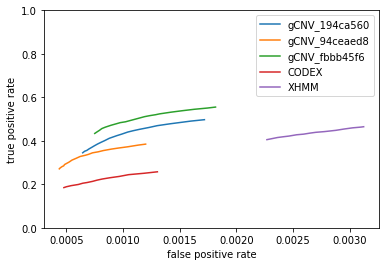

In [8]:
min_variant_frequency = 0.0
max_variant_frequency = 1.0
truth_min_quality = 0
min_length = 0

fdr_lists = []
tpr_lists = []
fpr_lists = []

for trial_summary_dict in trial_summary_dicts:

    fdr_list, tpr_list, fpr_list = get_roc_curve(
        mutual_samples,
        trial_summary_dict,
        min_variant_frequency,
        max_variant_frequency,
        min_length,
        truth_min_quality=truth_min_quality,
        trial_max_quality=99)
    
    fdr_lists.append(fdr_list)
    tpr_lists.append(tpr_list)
    fpr_lists.append(fpr_list)

for fpr_list, tpr_list, trial_name in zip(fpr_lists, tpr_lists, trial_names):
    plt.plot(fpr_list, tpr_list, label=trial_name)

# plt.xlim((0, 1))
plt.ylim((0, 1))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
# plt.gca().set_aspect('equal')

## Sensivitiy vs. variant frequency

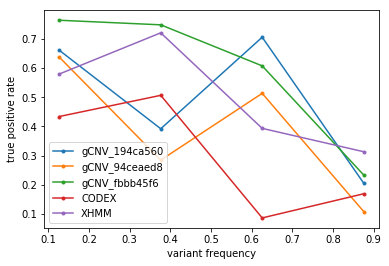

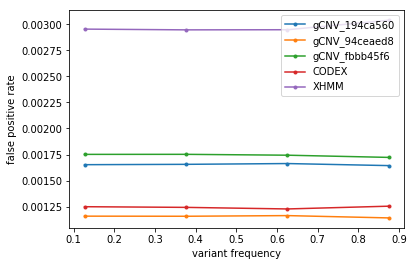

In [18]:
def get_sensitivity_variant_frequency_list(sample_names, summary_dict):
    variant_frequency_grid = np.linspace(0.002, 1.0, 5)
    min_variant_frequency_list = np.asarray(variant_frequency_grid[:-1])
    max_variant_frequency_list = np.asarray(variant_frequency_grid[1:])
    variant_frequency_mid = 0.5 * (min_variant_frequency_list + max_variant_frequency_list)
    tpr_list = []
    fpr_list = []
    total_calls = []
    for min_variant_frequency, max_variant_frequency in zip(min_variant_frequency_list, max_variant_frequency_list):
        
        truth_filter = cnv_eval.GenericCopyNumberVariant.get_variant_filter(
            min_variant_frequency=min_variant_frequency,
            max_variant_frequency=max_variant_frequency,
            included_variant_classes={'mixed'})
        
        trial_filter = cnv_eval.GenericCopyNumberVariant.get_variant_filter()
        
        concordance = get_concordance_from_summary_dict(sample_names, summary_dict, truth_filter, trial_filter)
        total_calls.append(concordance.TP + concordance.FN)
        tpr_list.append(concordance.TPR)
        fpr_list.append(concordance.FPR)
    
    return variant_frequency_mid, tpr_list, fpr_list, total_calls

fig1 = plt.figure()
ax1 = plt.gca()
ax1.set_xlabel('variant frequency')
ax1.set_ylabel('true positive rate')

fig2 = plt.figure()
ax2 = plt.gca()
ax2.set_xlabel('variant frequency')
ax2.set_ylabel('false positive rate')

for trial_summary_dict, trial_name in zip(trial_summary_dicts, trial_names):
    vf_list, tpr_list, fpr_list, total_calls = get_sensitivity_variant_frequency_list(
        mutual_samples, trial_summary_dict)
    ax1.plot(vf_list, tpr_list, label=trial_name, marker='.')
    ax2.plot(vf_list, fpr_list, label=trial_name, marker='.')
    
ax1.legend()
ax2.legend()